# Pirámides de Gauss y Laplace

## Autor: Benjamín Irarrázabal Thamm

# Importar librerias e iniciar notebook

In [1]:
# Si se usa colaboratory, esta linea permite subir imagenes a la carpeta del notebook
# Si no funciona en firefox, se puede desactivar el "enhanced protection" en "security shield" a la izquierda del url
from google.colab import files
uploaded = files.upload()

Saving corteza_2022.jpg to corteza_2022.jpg
Saving dali_2022.jpg to dali_2022.jpg
Saving origami_2022.jpg to origami_2022.jpg
Saving techo_falso_2022.jpg to techo_falso_2022.jpg


In [2]:
# Mostrar archivos en la carpeta del notebook
!ls

corteza_2022.jpg  origami_2022.jpg  techo_falso_2022.jpg
dali_2022.jpg	  sample_data


In [3]:
# Para medir tiempo de ejecucion
!pip install ipython-autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 5.0 MB/s 


In [4]:
# Extensiones
%load_ext Cython
%load_ext autotime

time: 303 µs (started: 2022-09-04 22:56:39 +00:00)


In [5]:
# Paquetes a ser usados
import numpy as np
import cv2
import cython
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import cm
# Este paquete solo se debe usar si se usa colaboratory
from google.colab.patches import cv2_imshow

time: 563 ms (started: 2022-09-04 22:56:39 +00:00)


# Pirámide de Gauss

In [6]:
%%cython
import cython
import numpy as np
cimport numpy as np

# La convolucion debe ser implementada usando cython (solo esta funcion en cython)
#@cython.boundscheck(False)
cpdef np.ndarray[np.float32_t, ndim=2] convolution_cython(np.ndarray[np.float32_t, ndim=2] input, np.ndarray[np.float32_t, ndim=2] mask):
  cdef int row, col, rows, cols, mask_centerR, mask_centerC, i, j # se agregan 4 variables nuevas para manejar las posiciones de la iteración.
  cdef float sum
  cdef np.ndarray[np.float32_t, ndim=2] output=np.zeros([input.shape[0], input.shape[1]], dtype = np.float32)

  # tamano de la imagen
  rows = input.shape[0]
  cols = input.shape[1]

  # Buscamos el centro del kernel (R=row, C=column), para poder iterar la convolución.
  mask_centerR = mask.shape[0] // 2
  mask_centerC = mask.shape[1] // 2


  # A continuación se cambiaron los atributos de la función range para poder ubicar
  # correctamente el centro del kernel y evitar errores.
  for row in range(mask_centerR, rows - mask_centerR):
    for col in range(mask_centerC, cols - mask_centerC):
      sum = 0 # se define sum dentro de la iteración para luego ser modificado únicamente con las multiplicaciones entre input y kernel.
      for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
          sum += (input[row - mask_centerR + i][col - mask_centerC + j] * mask[-i-1][-j-1]) # recorre el vecindario del píxel objetivo realizando la combinación lineal necesaria.
          output[row][col] = sum # guarda el resultado en el píxel deseado

  # Retornar la imagen resultante post-convolución sin valores en 0.
  return output


time: 1.83 s (started: 2022-09-04 22:56:41 +00:00)


In [7]:
"""
Test de la función de convolución, se crea un arreglo matricial de input (simulando una imagen de entrada) y una máscara sencilla para comprobar el funcionamiento.
Se realiza un cambio de tipo a float32 de los arreglos para corregir errores y se comprueba el funcionamiento.
Finalmente, se observa que se realiza correctamente la convolución, obteniendo una salida del mismo tamaño que la entrada con ceros en los extremos.
"""
input = np.arange(1,82)
input = input.reshape(9,9)
kernel = np.array([[0,0,0],[0,1,0],[0,0,0]])
input = np.float32(input)
kernel = np.float32(kernel)
C = convolution_cython(input, kernel)
print(C)

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. 11. 12. 13. 14. 15. 16. 17.  0.]
 [ 0. 20. 21. 22. 23. 24. 25. 26.  0.]
 [ 0. 29. 30. 31. 32. 33. 34. 35.  0.]
 [ 0. 38. 39. 40. 41. 42. 43. 44.  0.]
 [ 0. 47. 48. 49. 50. 51. 52. 53.  0.]
 [ 0. 56. 57. 58. 59. 60. 61. 62.  0.]
 [ 0. 65. 66. 67. 68. 69. 70. 71.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]]
time: 7.12 ms (started: 2022-09-04 22:56:43 +00:00)


In [8]:
def compute_gauss_mask_2d(sigma, width):
  gmask = np.zeros((width, width), np.float32)

  center = width // 2 # centro de la máscara
  ax = np.linspace(-center, center, width) # se define un arreglo 
  for i in range(len(ax)): # Filas
    for j in range(len(ax)): # Columnas
      # se definen variables auxiliares
      x = ax[i] 
      y = ax[j]
      gmask[i][j] = (1/(2*np.pi*np.square(sigma))) * (np.exp(-0.5 * (np.square(x)+np.square(y)) / np.square(sigma))) # se computan los píxeles de la máscara

  return gmask / np.sum(gmask) # Se normaliza dividiendo por la suma total dentro de la matriz

time: 3.5 ms (started: 2022-09-04 22:56:43 +00:00)


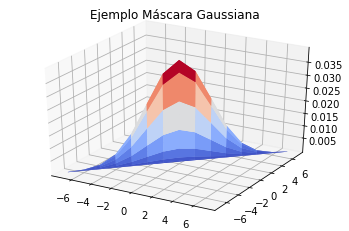

time: 234 ms (started: 2022-09-04 22:56:43 +00:00)


In [9]:
"""
Test de la función generadora de una máscara gaussiana a partir del largo (width) y el sigma (desviación).
"""
width = 15
sigma = 2.0
gmask = compute_gauss_mask_2d(sigma, width)
#print(gmask, np.sum(gmask))
width = gmask.shape[0]
center = width // 2

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = np.linspace(-center, center, width)
y = np.linspace(-center, center, width)

ax.plot_surface(x, y, gmask, cmap = cm.coolwarm)

plt.title('Ejemplo Máscara Gaussiana')

plt.show()

In [10]:
def apply_blur(input, sigma, width):
  # Se computa una máscara gaussiana tomando los atributos de entrada
  gmask = compute_gauss_mask_2d(sigma, width)
  # Se aplica una convolución matricial usando la máscara generada en la línea anterior
  return convolution_cython(input, gmask)

time: 1.21 ms (started: 2022-09-04 22:56:43 +00:00)


In [11]:
def do_subsample(img):
  r,c = img.shape
  output = np.zeros((r//2, c//2), np.float32)
  for i in range(output.shape[0]):
    for j in range(output.shape[1]):
      output[i][j] = img[2*i][2*j]
  return output

time: 1.94 ms (started: 2022-09-04 22:56:43 +00:00)


In [12]:
def calc_gauss_pyramid(input, levels):  
  gausspyr = [] # Lista que guarda las imágenes de la pirámide

  current = np.copy(input) # Primera imagen (sin modificaciones)
  gausspyr.append(current)

  for i in range(1,levels):
    current = apply_blur(gausspyr[i-1], 2.0, 7) # Se aplica una convolución a la imagen en i-1
    current = do_subsample(current) # Se realiza submuestreo del resultado anterior
    gausspyr.append(current) # Se agrega a la lista
  return gausspyr # Se retorna la lista

time: 2.15 ms (started: 2022-09-04 22:56:43 +00:00)


In [13]:
def show_gauss_pyramid(pyramid):
  # Recorre la lista y muestra las imágenes hacia abajo
  for imagen in pyramid:
    cv2_imshow(imagen)

time: 1.04 ms (started: 2022-09-04 22:56:43 +00:00)


# Pirámide de Laplace

In [14]:
def subtract(input1, input2):
  # Por hacer: calcular la resta entre input1 e input2, pixel a pixel
  x = input1.shape[0]
  y = input1.shape[1]
  output = np.zeros((x,y), np.float32)
  for i in range(x):
    for j in range(y):
      output[i][j] = input1[i][j] - input2[i][j]
  return output

time: 2.14 ms (started: 2022-09-04 22:56:44 +00:00)


In [15]:
def add(input1, input2):
  x, y = input1.shape
  output = np.zeros((x,y), np.float32)
  for i in range(x):
    for j in range(y):
      try:
        output[i][j] += (input1[i][j] + input2[i][j])
      except:
        pass
  return output

time: 2.18 ms (started: 2022-09-04 22:56:44 +00:00)


In [16]:
def calc_laplace_pyramid(input, levels):
  gausspyr = []
  laplacepyr = []
  current = np.copy(input)
  gausspyr.append(current)
  for i in range(1, levels):
    # 1) Aplicar apply_blur( ) a la imagen gausspyr[i-1], con sigma 2.0 y ancho 7
    current = apply_blur(gausspyr[i-1], 2.0, 7)
    # 2) Guardar en laplacepyr el resultado de restar gausspyr[i-1] y la imagen calculada en (1)
    resta = subtract(gausspyr[i-1], current)
    laplacepyr.append(resta)
    # 3) Submuestrear la imagen calculada en (1), guardar el resultado en current
    current = do_subsample(current)
    gausspyr.append(current)
  laplacepyr.append(current)  # Se agrega el ultimo piso de la piramide de Laplace
  return laplacepyr

time: 2.48 ms (started: 2022-09-04 22:56:44 +00:00)


In [17]:
def show_laplace_pyramid(pyramid):
  """
  pyramid: arreglo de imágenes

  La función toma este arreglo de entrada y lo recorre píxel a píxel hasta la penúltima
  posición aplicando el valor absoluto, lo anterior debido a que la última imagen es idéntica a la última de la pirámide de Gauss y no
  requiere de la aplicación de esta función. Finalmente, se recorre nuevamente el arreglo mostrando las imágenes en pantalla.
  """
  pyramid2 = np.copy(pyramid)
  for k in range(len(pyramid2)-1):
    for i in range(pyramid2[k].shape[0]):
      for j in range(pyramid2[k].shape[1]):
        (pyramid2[k])[i][j] = np.abs((pyramid2[k])[i][j]) * 6# por factor
  for imagen in pyramid2:
    cv2_imshow(imagen)

time: 12.8 ms (started: 2022-09-04 22:56:44 +00:00)


## Reconstrucción

In [18]:
def do_upsample(img):
  x, y = img.shape
  upsample = np.zeros((2*x, 2*y), np.float32)

  for i in range(2*x-2):
    for j in range(2*y-2):
      if (i%2==0) and (j%2==0):
        upsample[i][j] = img[i//2][j//2]
      elif (i%2==0) and (j%2!=0):
        upsample[i][j] = (img[i//2][j//2] + img[i//2][(j+1)//2]) / 2
      elif (i%2!=0) and (j%2==0):
        upsample[i][j] = (img[i//2][j//2] + img[(i+1)//2][j//2]) / 2
      else:
        upsample[i][j] = (img[i//2][j//2] + img[(i+1)//2][j//2] + img[i//2][(j+1)//2] + img[(i+1)//2][(j+1)//2]) / 4

  return upsample

time: 4.82 ms (started: 2022-09-04 22:56:44 +00:00)


In [19]:
def do_reconstruct(laplacepyr):
  output = np.copy( laplacepyr[len(laplacepyr)-1] )
  for i in range(1, len(laplacepyr)):
    level = int(len(laplacepyr)) - i - 1

    output = do_upsample(output)

    output = add(output, laplacepyr[level])
    output = output
  return output

time: 1.92 ms (started: 2022-09-04 22:56:44 +00:00)


In [20]:
ls

corteza_2022.jpg  origami_2022.jpg  techo_falso_2022.jpg
dali_2022.jpg     sample_data/
time: 126 ms (started: 2022-09-04 22:56:45 +00:00)


# Resultados parte A y B

Piramide de gauss:


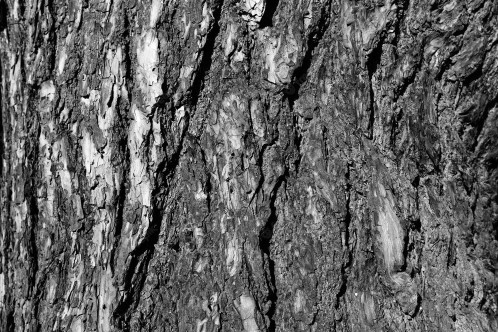

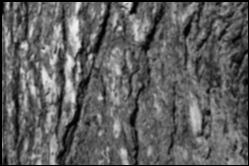

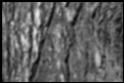

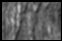

reconstruida:


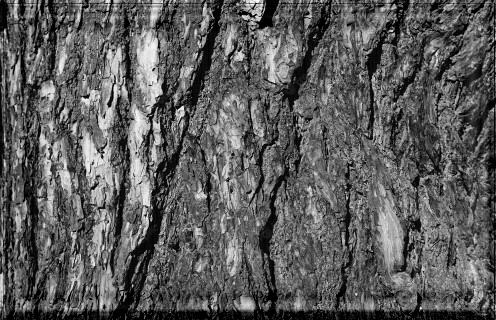

Piramide de laplace:


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:804: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, order=order, subok=subok, copy=True)


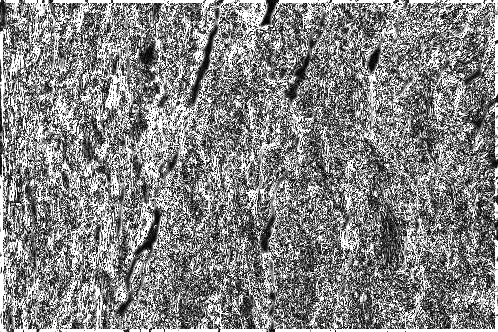

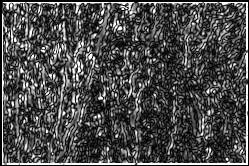

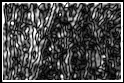

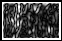

time: 53.4 s (started: 2022-09-02 21:59:52 +00:00)


In [ ]:
originalBGR = cv2.imread('corteza_2022.jpg') #Leer imagen

if originalBGR is None:
  assert False, 'Imagen no encontrada'

if len(originalBGR.shape) == 3:
  original = cv2.cvtColor(originalBGR, cv2.COLOR_BGR2GRAY)
else:
  original = originalBGR

input = np.float32( original )


print('Piramide de gauss:')
gausspyramid = calc_gauss_pyramid(input, 5)
show_gauss_pyramid(gausspyramid)



laplacepyramid = calc_laplace_pyramid(input, 5)

print('reconstruida:')
reconstr = do_reconstruct(laplacepyramid)
cv2_imshow(reconstr)


print('Piramide de laplace:')
show_laplace_pyramid(laplacepyramid)


Piramide de gauss:


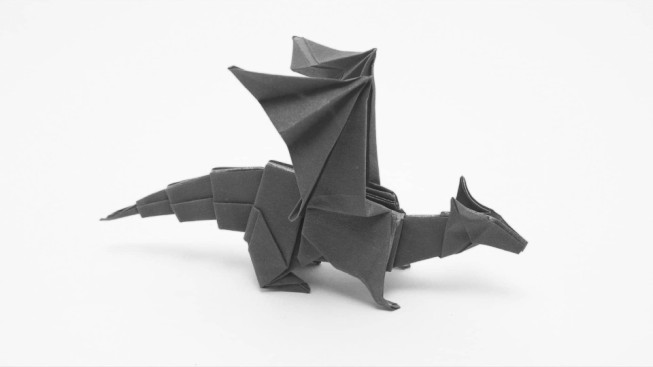

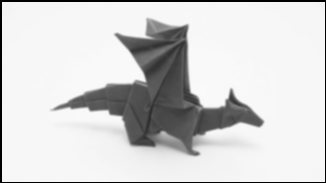

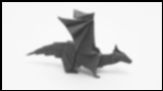

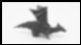

reconstruida:


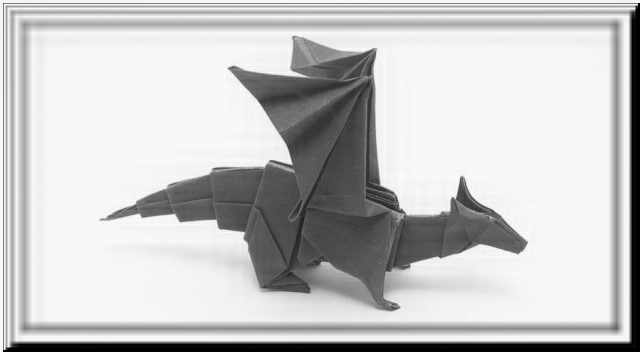

Piramide de laplace:


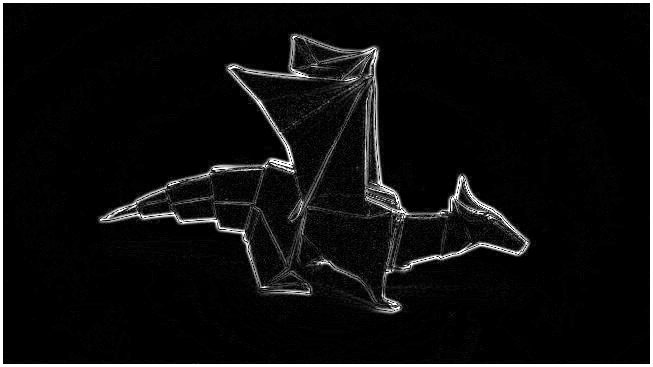

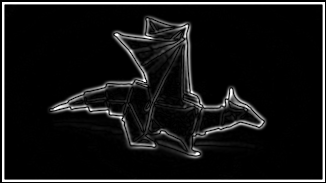

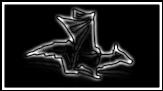

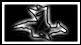

time: 1min 17s (started: 2022-09-01 14:38:59 +00:00)


In [ ]:
originalBGR = cv2.imread('origami_2022.jpg') #Leer imagen

if originalBGR is None:
  assert False, 'Imagen no encontrada'

if len(originalBGR.shape) == 3:
  original = cv2.cvtColor(originalBGR, cv2.COLOR_BGR2GRAY)
else:
  original = originalBGR

input = np.float32( original )

print('Piramide de gauss:')
gausspyramid = calc_gauss_pyramid(input, 5)
show_gauss_pyramid(gausspyramid)

laplacepyramid = calc_laplace_pyramid(input, 5)


print('reconstruida:')
reconstr = do_reconstruct(laplacepyramid)
cv2_imshow(reconstr)


print('Piramide de laplace:')

show_laplace_pyramid(laplacepyramid)



Piramide de gauss:


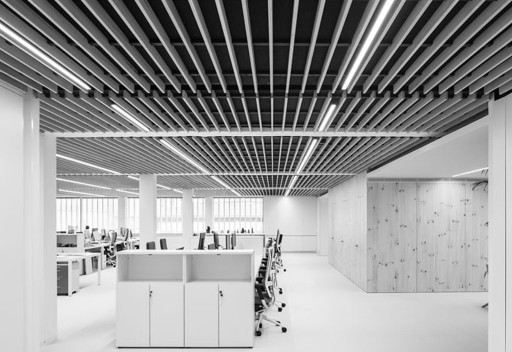

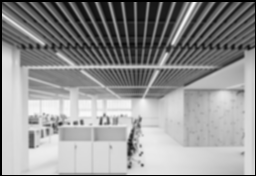

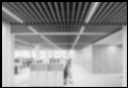

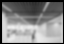

reconstruida:


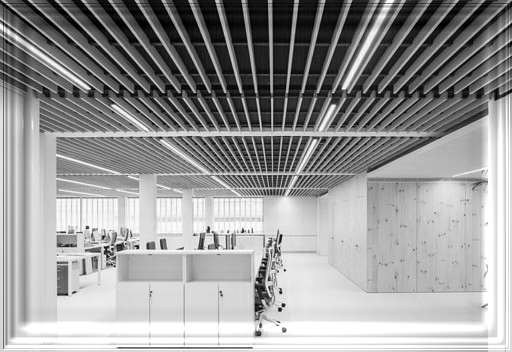

Piramide de laplace:


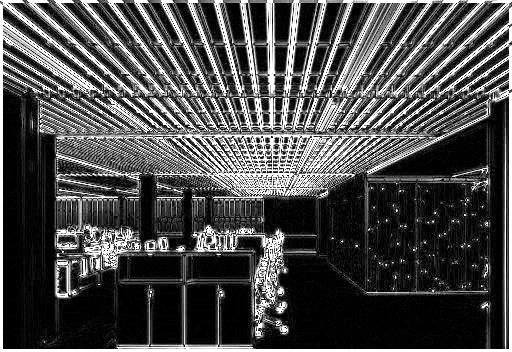

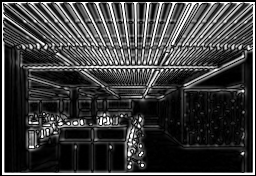

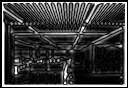

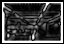

time: 1min 2s (started: 2022-09-01 14:41:12 +00:00)


In [ ]:
originalBGR = cv2.imread('techo_falso_2022.jpg') #Leer imagen

if originalBGR is None:
  assert False, 'Imagen no encontrada'

if len(originalBGR.shape) == 3:
  original = cv2.cvtColor(originalBGR, cv2.COLOR_BGR2GRAY)
else:
  original = originalBGR

input = np.float32( original )

print('Piramide de gauss:')
gausspyramid = calc_gauss_pyramid(input, 5)
show_gauss_pyramid(gausspyramid)

laplacepyramid = calc_laplace_pyramid(input, 5)

print('reconstruida:')
reconstr = do_reconstruct(laplacepyramid)
cv2_imshow(reconstr)


print('Piramide de laplace:')

show_laplace_pyramid(laplacepyramid)



Piramide de gauss:


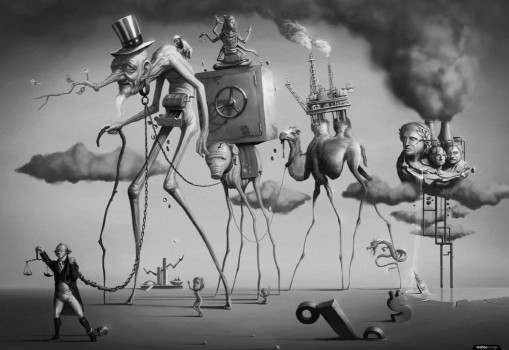

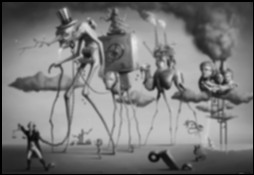

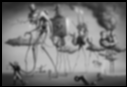

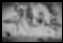

reconstruida:


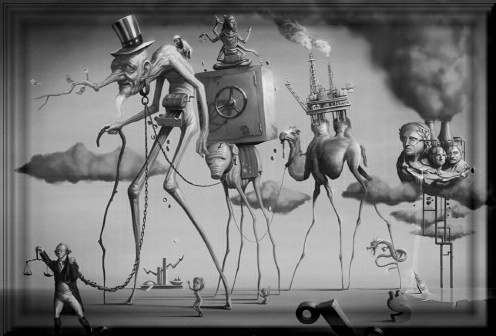

Piramide de laplace:


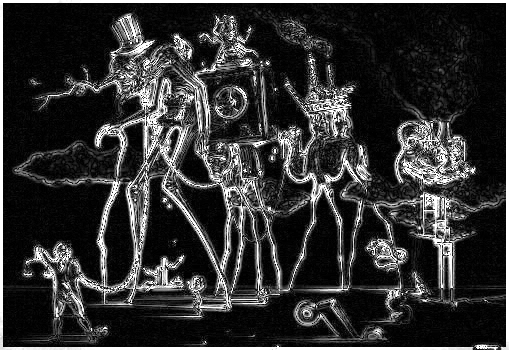

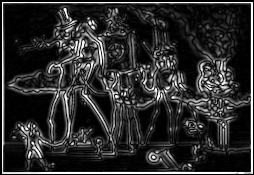

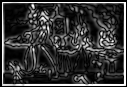

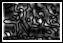

time: 59.8 s (started: 2022-09-01 14:42:15 +00:00)


In [ ]:
originalBGR = cv2.imread('dali_2022.jpg') #Leer imagen

if originalBGR is None:
  assert False, 'Imagen no encontrada'

if len(originalBGR.shape) == 3:
  original = cv2.cvtColor(originalBGR, cv2.COLOR_BGR2GRAY)
else:
  original = originalBGR

input = np.float32( original )

print('Piramide de gauss:')
gausspyramid = calc_gauss_pyramid(input, 5)
show_gauss_pyramid(gausspyramid)

laplacepyramid = calc_laplace_pyramid(input, 5)

print('reconstruida:')
reconstr = do_reconstruct(laplacepyramid)
cv2_imshow(reconstr)

print('Piramide de laplace:')

show_laplace_pyramid(laplacepyramid)



# Filtrado Pasa-Altos

## Laplacian of Gaussian (LoG)

In [21]:
def LoG(sigma, width):
  LoG_X = np.zeros((width, width), np.float32)
  LoG_Y = np.zeros((width, width), np.float32)
  center = width // 2
  ax = np.linspace(-center, center, width)
  for j in range(len(ax)):
    x = ax[j]
    LoG_X[center][j] = (((x**2) / (sigma**4)) - (1/(sigma**2))) * np.exp(-0.5 * (x**2) / (sigma**2))
  for i in range(len(ax)):
    y = ax[i]
    LoG_Y[i][center] = (((y**2) / (sigma**4)) - (1/(sigma**2))) * np.exp(-0.5 * (y**2) / (sigma**2))
  return LoG_X / np.sum(np.abs(LoG_X)), LoG_Y / np.sum(np.abs(LoG_Y))

time: 6.16 ms (started: 2022-09-04 22:57:16 +00:00)


In [23]:
def apply_LoG(img, sigma, width):
  r, c = img.shape
  output = np.zeros((r,c), np.float32)

  LoG_X, LoG_Y = LoG(sigma, width)

  Dx = convolution_cython(img, LoG_X)
  Dy = convolution_cython(img, LoG_Y)
  
  output = np.sqrt(np.square(Dx) + np.square(Dy))
  return output

time: 8.85 ms (started: 2022-09-04 22:57:38 +00:00)


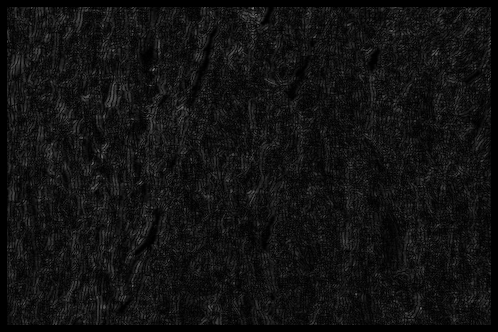

time: 2min 48s (started: 2022-09-02 22:52:23 +00:00)


In [ ]:
originalBGR = cv2.imread('corteza_2022.jpg') #Leer imagen

if originalBGR is None:
  assert False, 'Imagen no encontrada'

if len(originalBGR.shape) == 3:
  original = cv2.cvtColor(originalBGR, cv2.COLOR_BGR2GRAY)
else:
  original = originalBGR

input = np.float32( original )
out = apply_LoG(input, 1.4, 15)
cv2_imshow(out)

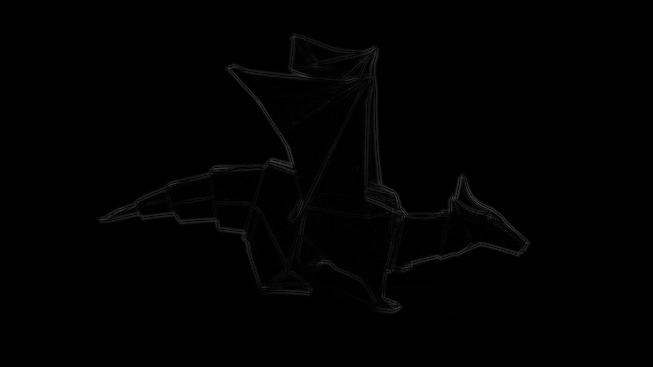

time: 4min 6s (started: 2022-09-02 22:58:36 +00:00)


In [ ]:
originalBGR = cv2.imread('origami_2022.jpg') #Leer imagen

if originalBGR is None:
  assert False, 'Imagen no encontrada'

if len(originalBGR.shape) == 3:
  original = cv2.cvtColor(originalBGR, cv2.COLOR_BGR2GRAY)
else:
  original = originalBGR

input = np.float32( original )
out = apply_LoG(input, 1, 15)
cv2_imshow(out)

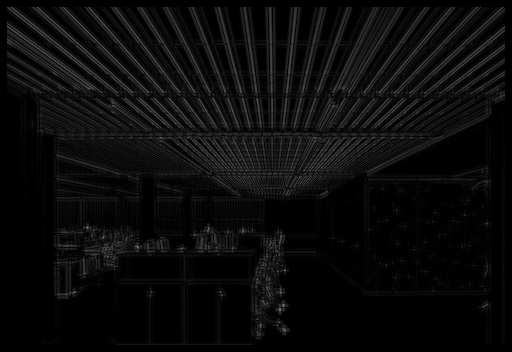

time: 3min 2s (started: 2022-09-02 23:03:21 +00:00)


In [ ]:
originalBGR = cv2.imread('techo_falso_2022.jpg') #Leer imagen

if originalBGR is None:
  assert False, 'Imagen no encontrada'

if len(originalBGR.shape) == 3:
  original = cv2.cvtColor(originalBGR, cv2.COLOR_BGR2GRAY)
else:
  original = originalBGR

input = np.float32( original )
out = apply_LoG(input, 1.4, 15)
cv2_imshow(out)

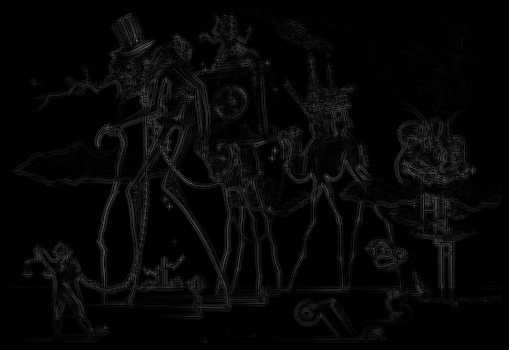

time: 2min 57s (started: 2022-09-02 23:10:50 +00:00)


In [ ]:
originalBGR = cv2.imread('dali_2022.jpg') #Leer imagen

if originalBGR is None:
  assert False, 'Imagen no encontrada'

if len(originalBGR.shape) == 3:
  original = cv2.cvtColor(originalBGR, cv2.COLOR_BGR2GRAY)
else:
  original = originalBGR

input = np.float32( original )
out = apply_LoG(input, 1, 15)
cv2_imshow(out)

## Derivative of Gaussian (DoG)

In [24]:
def DoG(sigma, width):
  DoG_X = np.zeros((width, width), np.float32)
  DoG_Y = np.zeros((width, width), np.float32)
  center = width // 2
  ax = np.linspace(-center, center, width)
  for j in range(len(ax)):
    x = ax[j]
    DoG_X[center][j] = (-x/(sigma**2)) * np.exp(-0.5 * (x**2) / (sigma**2))
  for i in range(len(ax)):
    y = ax[i]
    DoG_Y[i][center] = (-y/(sigma**2)) * np.exp(-0.5 * (y**2) / (sigma**2))
  return DoG_X / np.sum(np.abs(DoG_X)), DoG_Y / np.sum(np.abs(DoG_Y))

time: 4.22 ms (started: 2022-09-04 22:57:44 +00:00)


In [25]:
def apply_DoG(img, sigma, width):
  r, c = img.shape
  output = np.zeros((r,c), np.float32)

  DoG_X, DoG_Y = DoG(sigma, width)

  Dx = convolution_cython(img, DoG_X)
  Dy = convolution_cython(img, DoG_Y)

  output = np.sqrt(np.square(Dx) + np.square(Dy))
  return output

time: 1.36 ms (started: 2022-09-04 22:57:46 +00:00)


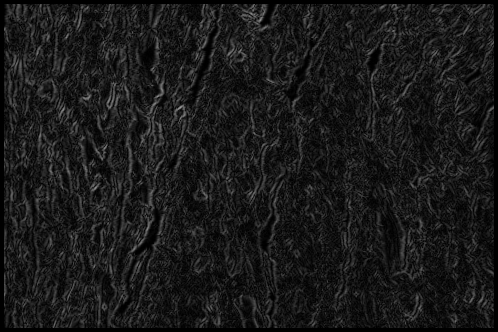

time: 1min 1s (started: 2022-09-02 23:30:57 +00:00)


In [ ]:
originalBGR = cv2.imread('corteza_2022.jpg') #Leer imagen

if originalBGR is None:
  assert False, 'Imagen no encontrada'

if len(originalBGR.shape) == 3:
  original = cv2.cvtColor(originalBGR, cv2.COLOR_BGR2GRAY)
else:
  original = originalBGR

input = np.float32( original )
out = apply_DoG(input, 1.4, 9)
cv2_imshow(out)

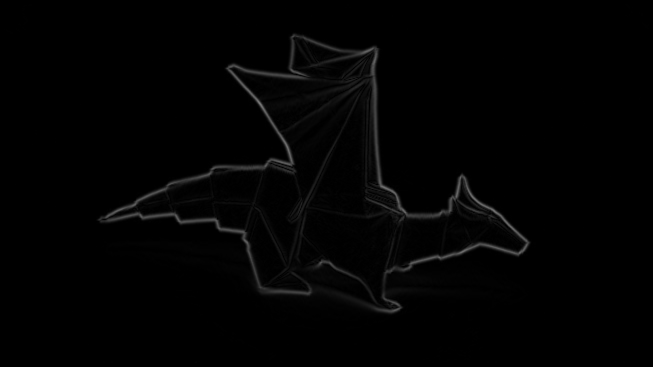

time: 1min 29s (started: 2022-09-02 23:33:51 +00:00)


In [ ]:
originalBGR = cv2.imread('origami_2022.jpg') #Leer imagen

if originalBGR is None:
  assert False, 'Imagen no encontrada'

if len(originalBGR.shape) == 3:
  original = cv2.cvtColor(originalBGR, cv2.COLOR_BGR2GRAY)
else:
  original = originalBGR

input = np.float32( original )
out = apply_DoG(input, 1.4, 9)
cv2_imshow(out)

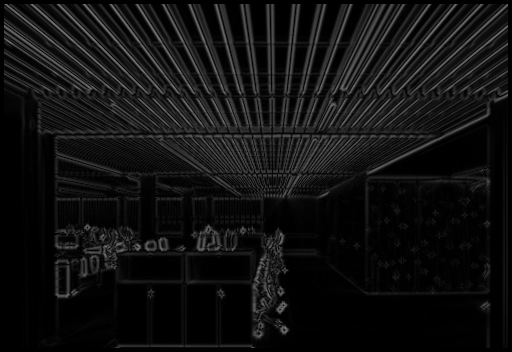

time: 1min 6s (started: 2022-09-02 23:35:21 +00:00)


In [ ]:
originalBGR = cv2.imread('techo_falso_2022.jpg') #Leer imagen

if originalBGR is None:
  assert False, 'Imagen no encontrada'

if len(originalBGR.shape) == 3:
  original = cv2.cvtColor(originalBGR, cv2.COLOR_BGR2GRAY)
else:
  original = originalBGR

input = np.float32( original )
out = apply_DoG(input, 1.4, 9)
cv2_imshow(out)

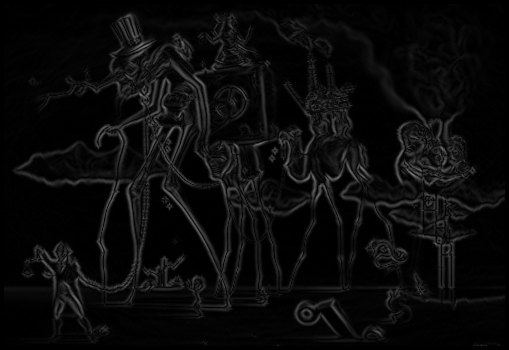

time: 1min 5s (started: 2022-09-02 23:36:28 +00:00)


In [ ]:
originalBGR = cv2.imread('dali_2022.jpg') #Leer imagen

if originalBGR is None:
  assert False, 'Imagen no encontrada'

if len(originalBGR.shape) == 3:
  original = cv2.cvtColor(originalBGR, cv2.COLOR_BGR2GRAY)
else:
  original = originalBGR

input = np.float32( original )
out = apply_DoG(input, 1.4, 9)
cv2_imshow(out)

## Filtrado v/s Laplace

Pirámide Filtrada LoG


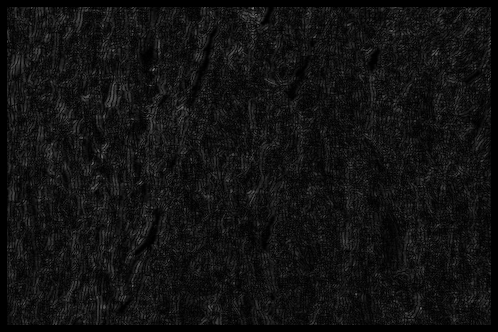

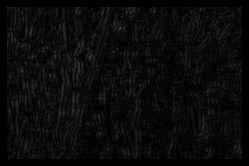

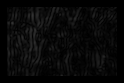

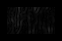

Pirámide Filtrada DoG


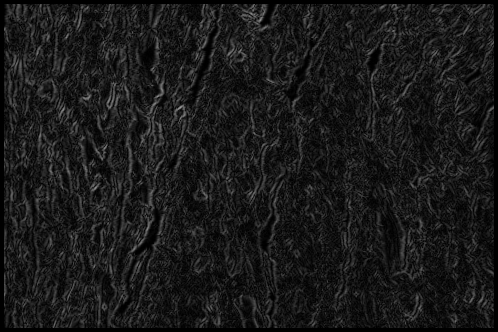

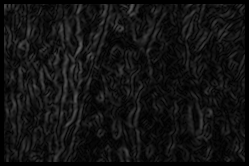

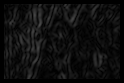

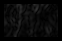

time: 5min 8s (started: 2022-09-03 01:43:34 +00:00)


In [ ]:
originalBGR = cv2.imread('corteza_2022.jpg') #Leer imagen

if originalBGR is None:
  assert False, 'Imagen no encontrada'

if len(originalBGR.shape) == 3:
  original = cv2.cvtColor(originalBGR, cv2.COLOR_BGR2GRAY)
else:
  original = originalBGR

input = np.float32( original )
gauss = calc_gauss_pyramid(input, 5)
#laplace = calc_laplace_pyramid(input, 5)

P_filtrada_LoG = []
P_filtrada_DoG = []

for i in range(len(gauss)):
  P_filtrada_LoG.append(apply_LoG(gauss[i], 1.4, 15))
  P_filtrada_DoG.append(apply_DoG(gauss[i], 1.4, 9))


print('Pirámide Filtrada LoG')
for img in P_filtrada_LoG:
  cv2_imshow(img)

print('Pirámide Filtrada DoG')
for img in P_filtrada_DoG:
  cv2_imshow(img)

Pirámide Filtrada LoG


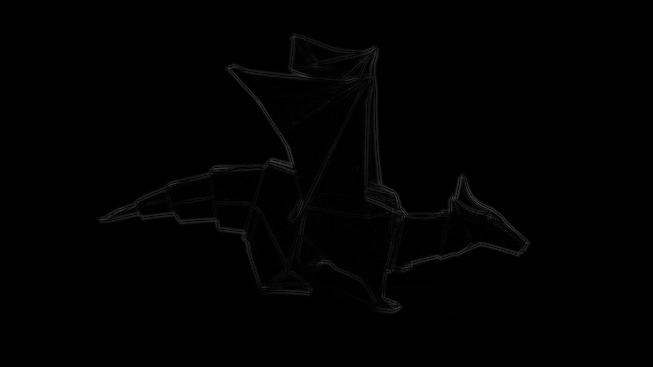

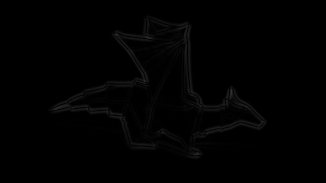

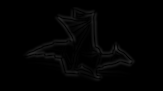

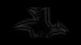

Pirámide Filtrada DoG


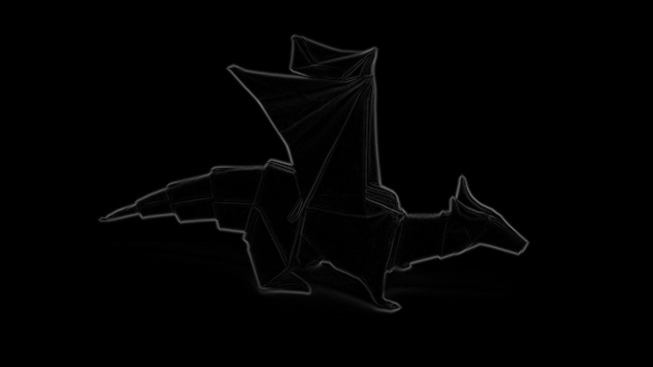

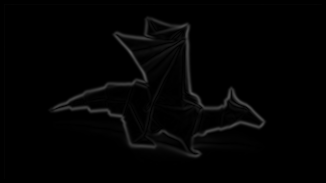

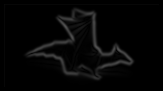

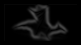

time: 7min 32s (started: 2022-09-03 01:50:58 +00:00)


In [ ]:
originalBGR = cv2.imread('origami_2022.jpg') #Leer imagen

if originalBGR is None:
  assert False, 'Imagen no encontrada'

if len(originalBGR.shape) == 3:
  original = cv2.cvtColor(originalBGR, cv2.COLOR_BGR2GRAY)
else:
  original = originalBGR

input = np.float32(original)
gauss = calc_gauss_pyramid(input, 5)
#laplace = calc_laplace_pyramid(input, 5)

P_filtrada_LoG = []
P_filtrada_DoG = []

for i in range(len(gauss)):
  P_filtrada_LoG.append(apply_LoG(gauss[i], 1, 15))
  P_filtrada_DoG.append(apply_DoG(gauss[i], 1, 9))


print('Pirámide Filtrada LoG')
for img in P_filtrada_LoG:
  cv2_imshow(img)

print('Pirámide Filtrada DoG')
for img in P_filtrada_DoG:
  cv2_imshow(img)


Pirámide Filtrada LoG


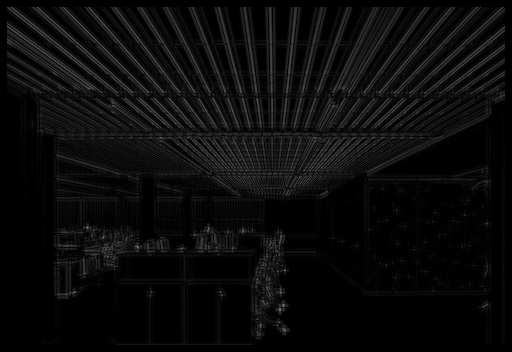

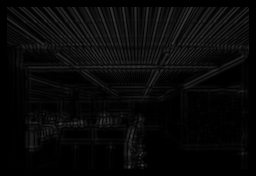

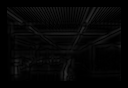

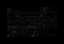

Pirámide Filtrada DoG


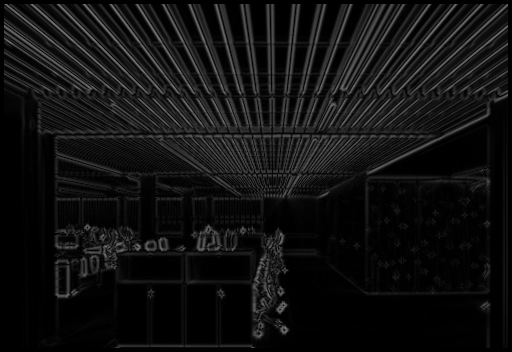

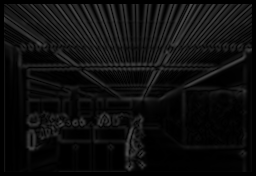

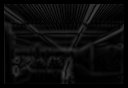

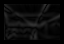

time: 6min 13s (started: 2022-09-04 23:02:55 +00:00)


In [26]:
originalBGR = cv2.imread('techo_falso_2022.jpg') #Leer imagen

if originalBGR is None:
  assert False, 'Imagen no encontrada'

if len(originalBGR.shape) == 3:
  original = cv2.cvtColor(originalBGR, cv2.COLOR_BGR2GRAY)
else:
  original = originalBGR

input = np.float32(original)
gauss = calc_gauss_pyramid(input, 5)
#laplace = calc_laplace_pyramid(input, 5)

P_filtrada_LoG = []
P_filtrada_DoG = []

for i in range(len(gauss)):
  P_filtrada_LoG.append(apply_LoG(gauss[i], 1.4, 15))
  P_filtrada_DoG.append(apply_DoG(gauss[i], 1.4, 9))


print('Pirámide Filtrada LoG')
for img in P_filtrada_LoG:
  cv2_imshow(img)

print('Pirámide Filtrada DoG')
for img in P_filtrada_DoG:
  cv2_imshow(img)

Pirámide Filtrada LoG


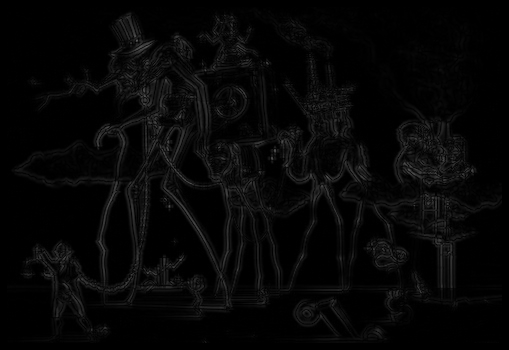

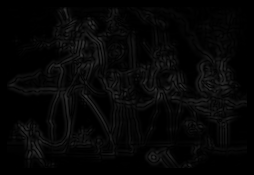

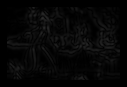

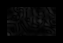

Pirámide Filtrada DoG


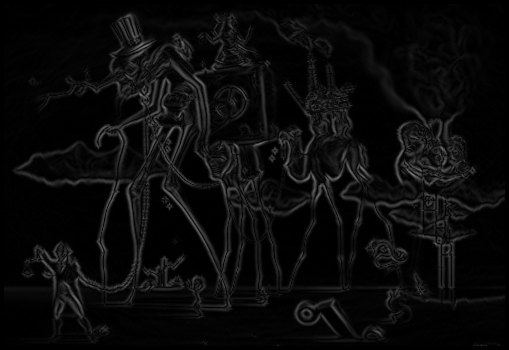

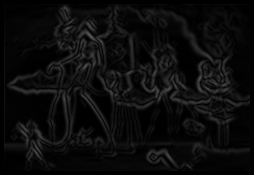

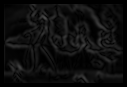

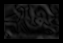

time: 6min 6s (started: 2022-09-04 23:09:08 +00:00)


In [27]:
originalBGR = cv2.imread('dali_2022.jpg') #Leer imagen

if originalBGR is None:
  assert False, 'Imagen no encontrada'

if len(originalBGR.shape) == 3:
  original = cv2.cvtColor(originalBGR, cv2.COLOR_BGR2GRAY)
else:
  original = originalBGR

input = np.float32(original)
gauss = calc_gauss_pyramid(input, 5)
#laplace = calc_laplace_pyramid(input, 5)

P_filtrada_LoG = []
P_filtrada_DoG = []

for i in range(len(gauss)):
  P_filtrada_LoG.append(apply_LoG(gauss[i], 1.4, 15))
  P_filtrada_DoG.append(apply_DoG(gauss[i], 1.4, 9))


print('Pirámide Filtrada LoG')
for img in P_filtrada_LoG:
  cv2_imshow(img)

print('Pirámide Filtrada DoG')
for img in P_filtrada_DoG:
  cv2_imshow(img)